## My first pytorch model
* This is just an introduction of creating a pytorch model and refresh the basics.
* We will create a ML classifier to detect playing cards
* This is the dataset: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys

### Pytorch Dataset 


In [2]:
class PlayingCardDataset(Dataset):
    def __init__(self,data_dir,transform = None):
        # Image folder helps take the sub folder name in dir and assumes as the image label and creates it automatically
        self.data = ImageFolder(data_dir,transform=transform)

        pass
    # How many examples does the dataset contain
    def __len__(self):
        return len(self.data)
    # Get the particular instance of the dataset
    def __getitem__(self, index):
        return self.data[index]
    # Get the name of the classes in the dataset
    def classes(self):
        return self.data.classes

In [3]:
data_dir='Dataset/archive/train'
dataset = PlayingCardDataset(data_dir)

In [4]:
## Get a dictionary associating target values with folder names
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
# print(target_to_class)

In [5]:
# We want the image to be in same size.
transform = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
data_dir='Dataset/archive/train'
dataset = PlayingCardDataset(data_dir,transform=transform)

In [6]:
# We are going to create the dataset for a pytorch model. We are going to create a batch size and a shuffle
# Shuffling is done in training data only.
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)
for images, labels in dataloader:
    break
print(images.shape,labels.shape)

torch.Size([32, 3, 128, 128]) torch.Size([32])


### Pytorch model
 * we are going to use some pre-defined model using tim.


In [7]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes = 53):
        # Where we define all the parts of the model
        # This below super is added because it needs to enhirt from the parent class.
        super(SimpleCardClassifier, self).__init__()
        # We are using the efficient b0 architecture. bo is the size of the model
        # Pretrained = true, is the weights have already been tune based on imagenet dataset.
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        # The base model has an additional layer, which we want to remove. The below code helps you do that.

        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        # The output of the model feature size is 1280
        enet_out_size = 1280
        self.classifier = nn.Sequential(nn.Flatten(),nn.Linear(enet_out_size, num_classes))
    def forward(self,x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [8]:
model = SimpleCardClassifier()
# The output is batchsize x value
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

### Training Loop

In [9]:
# First thing is to determine the loss function and optimizer
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion(example_out, labels)
# print(example_out.shape, labels.shape)


In [10]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = 'Dataset/archive/train'
valid_folder = 'Dataset/archive/valid'
test_folder = 'Dataset/archive/test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [15]:
# Simple training loop
from tqdm.notebook import tqdm
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Training loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Training loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5843502129862967, Validation loss: 0.41795384119141776


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Training loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5483181922846051, Validation loss: 0.23636508235391582


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Training loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.3372476938545141, Validation loss: 0.12883385532307176


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Training loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.228427951211444, Validation loss: 0.11845365459064268


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Training loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.1848570538268416, Validation loss: 0.11935470509079267


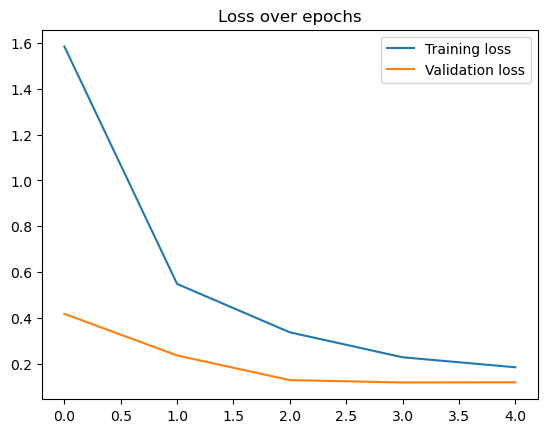

In [ ]:
# Visualization of the loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()